In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino


2025-04-24 18:08:10.092 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=None)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [4]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name = "togekiss-nn"
start_epoch=1
num_epochs=45
save_every=5
backup_every=10

# Hyper-parameters
BATCH_SIZE = 128
LR = 1e-3

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
model = BaseDino(head_layers=5, head_hidden_size=512, dropout_rate=0.0, unfreeze_blocks=1)
model.to(device)
# Optimizer, scheduler, and loss function
optimizer = SGD(model.parameters(), lr=LR)
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=15,           # First restart after 12 epochs
    T_mult=2,        # Double the interval between restarts each time
    eta_min=1e-6     # Minimum learning rate after annealing
)
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# # Model loading (uncomment to properly overwrite)
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/togekiss-nn_BaseDino_epoch_x.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/togekiss-nn_BaseDino_epoch_x.loss_acc.json")

# Preallocated lists: if the training interrupts, it will still save their values
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (net): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): Laye

In [5]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=False,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually. Backing up latest checkpoint...")

except Exception as e:
    print(f"Training stopped due to error: {e}")


Prefix/name for the model was provided: togekiss-nn

🚀 Epoch 1/45 (2.22%) Completed
	📊 Training Loss: 2.5520
	✅ Training Accuracy: 43.36%
	⏳ Elapsed Time: 83.44s | ETA: 3671.24s
	🕒 Completed At: 18:09
🔍 Validation Results:
	📉 Validation Loss: 1.4984
	🎯 Validation Accuracy: 57.08%

🚀 Epoch 2/45 (4.44%) Completed
	📊 Training Loss: 1.1626
	✅ Training Accuracy: 66.47%
	⏳ Elapsed Time: 84.69s | ETA: 3641.65s
	🕒 Completed At: 18:11
🔍 Validation Results:
	📉 Validation Loss: 1.1800
	🎯 Validation Accuracy: 66.69%

🚀 Epoch 3/45 (6.67%) Completed
	📊 Training Loss: 0.9878
	✅ Training Accuracy: 70.86%
	⏳ Elapsed Time: 83.97s | ETA: 3526.73s
	🕒 Completed At: 18:13
🔍 Validation Results:
	📉 Validation Loss: 1.1110
	🎯 Validation Accuracy: 67.46%

🚀 Epoch 4/45 (8.89%) Completed
	📊 Training Loss: 0.8788
	✅ Training Accuracy: 73.86%
	⏳ Elapsed Time: 84.07s | ETA: 3446.73s
	🕒 Completed At: 18:14
🔍 Validation Results:
	📉 Validation Loss: 1.0772
	🎯 Validation Accuracy: 69.61%

🚀 Epoch 5/45 (11.11%) Completed

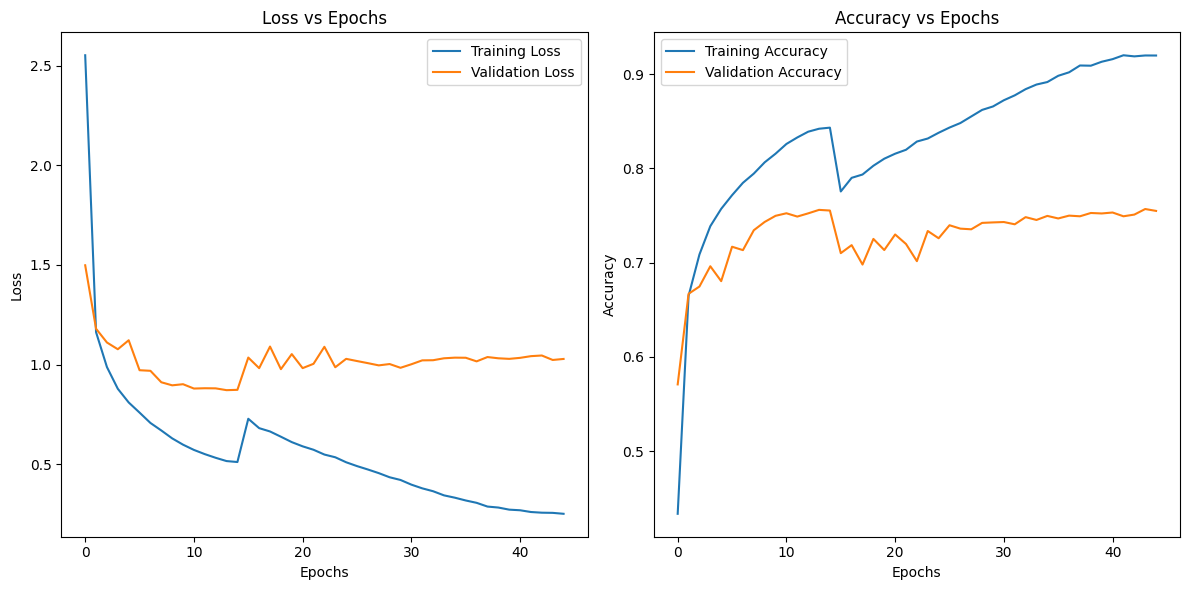

In [6]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

🔍 Test Results:
	📉 Test Loss: 1.0172
	🎯 Test Accuracy: 75.57%
